In [16]:
import pandas as pd
import os

# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\github-csvs'

# List to hold sequences
sequences = []

# Load all CSVs and extract sequences of loss values
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= 5:
                sequences.append(data['Loss'].values)  # assuming the column is named 'loss'
        except:
            print(filename)


KatayoonGoshvadi--Deep-Reinforcement-Learning-and-Control-HW1-2.csv
louadi--DSC-cons_vs_3-2.csv
louadi--DSC-cons_vs_es-2.csv
ltpitt--python-jupyter-face-generation-README-2.csv
LucasThierry--Neural-Networks-21.1-miniprojeto2-1.csv
luccasPh--trabalho-ia-cnn-relatorio-1.csv


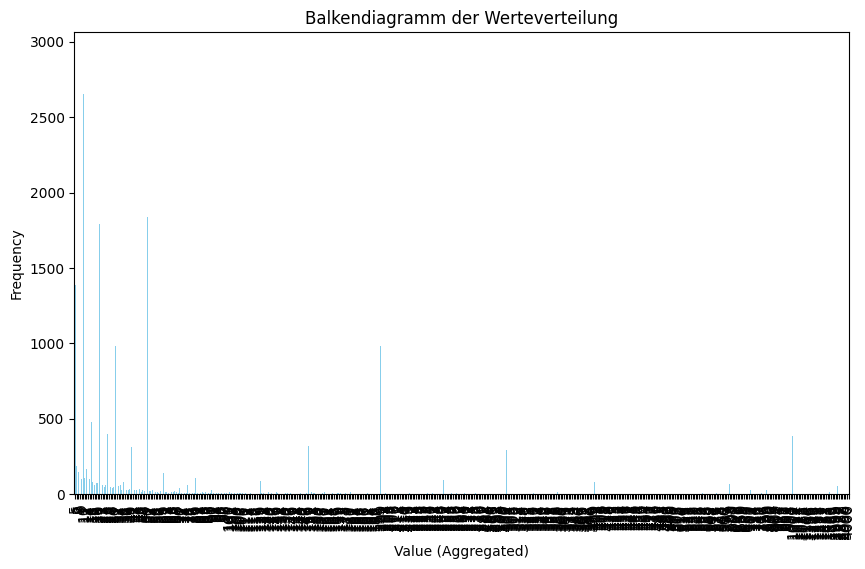

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Generate or load a large dataset
data = [len(df) for df in sequences]  # List of counts per DataFrame in sequences

# Convert data to a DataFrame for easy manipulation
df = pd.DataFrame(data, columns=['count'])

# Optional: Aggregate data to reduce the number of bars (e.g., by frequency counts)
df['count'].value_counts().sort_index().plot(kind='bar', color='skyblue', figsize=(10, 6))

plt.xlabel('Value (Aggregated)')
plt.ylabel('Frequency')
plt.title('Balkendiagramm der Werteverteilung')
plt.show()

In [21]:
import numpy as np

# Define window sizes
input_window = 5  # Input sequence length (n)
output_window = 3  # Output sequence length (m)

# Prepare input-output pairs from sequences
X = []
y = []

for sequence in sequences:
    # Create input-output pairs for each sequence
    for i in range(len(sequence) - input_window - output_window):
        X.append(sequence[i:i+input_window])
        y.append(sequence[i+input_window:i+input_window+output_window])

# Convert to numpy arrays for easier manipulation
X = np.array(X)
y = np.array(y)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

class LossPredictionTransformer(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3):
        super(LossPredictionTransformer, self).__init__()
        
        # Input and output embeddings for the transformer (linear layers for simplicity)
        self.input_embedding = nn.Linear(input_size, d_model)
        self.output_embedding = nn.Linear(input_size, d_model)
        
        # Transformer model
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers
        )
        
        # Final output layer to map to single loss value predictions
        self.fc_out = nn.Linear(d_model, input_size)

    def forward(self, src, tgt):
        # Embed the input and output sequences
        src_emb = self.input_embedding(src)
        tgt_emb = self.output_embedding(tgt)
        
        # Pass through the transformer
        transformer_output = self.transformer(src_emb, tgt_emb)
        
        # Map to final predictions
        output = self.fc_out(transformer_output)
        return output

# Initialize model
model = LossPredictionTransformer()


C:\Users\daV\miniconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [35]:
import sys
len(X_tensor.view(-1).tolist())  # 10M entries!

10465630

In [24]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add an extra dimension for input size
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Transformer expects (sequence_length, batch_size, d_model) shaped tensors
    X_train = X_tensor.permute(1, 0, 2)  # (sequence_length, batch_size, input_size)
    y_train = y_tensor.permute(1, 0, 2)
    
    # Predict next loss values
    output = model(X_train, y_train[:-1])  # Use teacher forcing for now
    
    # Compute the loss
    loss = criterion(output, y_train[1:])  # Compare against the actual future loss values
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()
    
    # Print training progress
    if epoch: #% 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 85734440960 bytes.

In [ ]:
def predict_next_losses(model, input_sequence, output_length=5):
    model.eval()
    
    # Convert input to tensor and reshape
    input_tensor = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_len, 1)
    input_tensor = input_tensor.permute(1, 0, 2)  # (sequence_length, batch_size, input_size)
    
    # Prepare initial target tensor with zeros
    target_tensor = torch.zeros(output_length, 1, 1)  # (output_length, batch_size, input_size)
    
    # Predict next loss values
    with torch.no_grad():
        predicted_loss = model(input_tensor, target_tensor)
    
    return predicted_loss.squeeze(-1).numpy()

# Example prediction
input_sequence = X[0]  # Use one of the training sequences
predicted_losses = predict_next_losses(model, input_sequence)
print("Predicted next losses:", predicted_losses)
